# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

In [6]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

In [245]:
import sklearn
sklearn.__version__

'1.0.2'

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation. 
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:

<img src="https://snag.gy/Gpi1Mk.jpg" width="600" >
<!-- ![alt text](https://snag.gy/Gpi1Mk.jpg) -->

Here is a little more deailed explanation (it's recommended to read the full paper).

<img src="https://snag.gy/koA0ue.jpg" width="600" >
<!-- ![alt_text](https://snag.gy/koA0ue.jpg) -->

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error. 
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below


<img src="https://i.ibb.co/0BGwVz7/1.png" width="600" >
<!-- ![](https://i.ibb.co/0BGwVz7/1.png) -->

In [215]:
class svm(BaseEstimator):
    def __init__(self, l=0.1, num_iteration=1000):
        self.l = l
        self.num_iteration = num_iteration
        self.w = None
    
    @staticmethod
    def pad(X):
        return np.append(np.ones([X.shape[0],1]),X,axis=1)
    
    @staticmethod
    def correct_labels(Y):
        Y_corrected = Y.copy()
        Y_corrected[Y_corrected == 0] = -1
        return(Y_corrected)

    def fit(self, X, Y):
        return self._fit(self.pad(X),self.correct_labels(Y))

    def _fit(self, X, Y):
        len_x = X.shape[1]
        self.w = np.zeros(len_x)
        for t in range(1, self.num_iteration+1):
            i = np.random.randint(0, len_x )
            x, y = X[i], Y[i]
            n = 1/(self.l * t)
            if y * np.dot(self.w ,x) < 1:
                self.w = (1 - n * self.l) * self.w + n * y * x
            else: 
                self.w = (1 - n * self.l) * self.w 
        return self.w

    def predict(self, X):
        return np.sign(np.dot(self.pad(X),self.w)) 

    def decision_function(self, X):
        return np.matmul( self.pad(X), self.w)

    def score(self, X, y):
        y_pred = self.predict(X)
        y_corrected = self.correct_labels(y)
        return (y_pred  == y_corrected).sum()/ len(y_corrected)



In [197]:

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)

for l in [0.001,0.01,0.1,1]:
    pp_svm = make_pipeline(StandardScaler(),  svm(l=l,num_iteration=1000))
    pp_svm.fit(X_train, y_train)
    print(f'For lambda={l:.4f} we get score: {pp_svm.score(X_test,y_test):.4f}')

For lambda=0.0010 we get score: 0.9301
For lambda=0.0100 we get score: 0.9371
For lambda=0.1000 we get score: 0.9301
For lambda=1.0000 we get score: 0.9371


In [200]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)

# pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=317))
clf.fit(X_train, y_train)
clf.decision_function(X_test)

print(f'For LinearSVC we get score: {clf.score(X_test,y_test):.4f}')


For LinearSVC we get score: 0.9580


In [217]:
from sklearn.model_selection import cross_val_score

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=317))
pp_svm = make_pipeline(StandardScaler(),  svm(l=0.01,num_iteration=1000))
print(f'Cross-validation for LinearSVC: {cross_val_score(clf, X, y, cv=3)}')
print(f'Cross-validation for our SVM implementation: {cross_val_score(pp_svm, X, y, cv=3)}')

Cross-validation for LinearSVC: [0.94736842 0.96842105 0.96825397]
Cross-validation for our SVM implementation: [0.93157895 0.92105263 0.86243386]


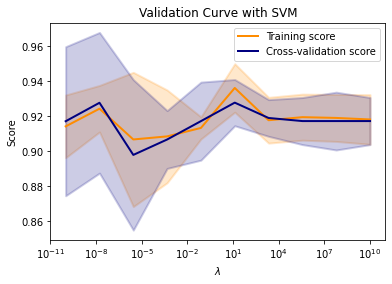

In [240]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

param_range=np.logspace(-10, 10, 10)
train_scores, test_scores  = validation_curve(
    pp_svm, X, y, param_name="svm__l",param_range=param_range ,
    cv=5)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\lambda$")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [258]:
X.shape

(569, 30)

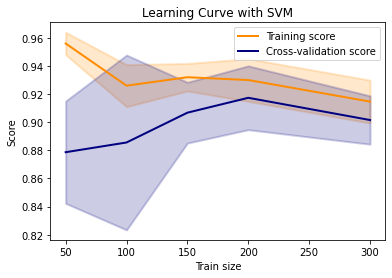

In [268]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
# https://github.com/scikit-learn/scikit-learn/blob/98cf537f5c538fdbc9d27b851cf03ce7611b8a48/sklearn/model_selection/_plot.py
 
train_sizes, train_scores, test_scores = learning_curve(pp_svm, X, y, train_sizes=[50,100,150,200,300], cv=5)

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.title("Learning Curve with SVM")
plt.xlabel("Train size")
plt.ylabel("Score")
# plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    train_sizes, train_scores_mean, label="Training score", color="darkorange", lw=lw
)

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    train_sizes, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and 
$$
p(y=0) = 0.1
$$. 

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`. 
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.


## Answer #

In [28]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process. 

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)

clf = make_pipeline(StandardScaler(),
                    LinearSVC(max_iter=50000))

parameters = {'linearsvc__multi_class':('ovr', 'crammer_singer'), 'linearsvc__loss':('hinge','squared_hinge'), 'linearsvc__C':np.logspace(-3,3,10)}

grid_GBC = GridSearchCV(clf, parameters)
grid_GBC.fit(X_train, y_train)

best_params = grid_GBC.best_params_

# sorted(gsc.cv_results_.keys())


print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params on TRAIN set:\n",grid_GBC.best_estimator_)
print("\n The best score across ALL searched params on TRAIN set:\n",grid_GBC.best_score_)
print("\n The best parameters across ALL searched params on TRAIN set:\n",best_params)



 Results from Grid Search 

 The best estimator across ALL searched params on TRAIN set:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(C=0.004641588833612777, loss='hinge', max_iter=50000,
                           multi_class='crammer_singer'))])

 The best score across ALL searched params on TRAIN set:
 0.9812585499316006

 The best parameters across ALL searched params on TRAIN set:
 {'linearsvc__C': 0.004641588833612777, 'linearsvc__loss': 'hinge', 'linearsvc__multi_class': 'crammer_singer'}


In [39]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)



clf = make_pipeline(StandardScaler(),LinearSVC())
clf.fit(X_train,y_train)
print(f'Score on TRAIN set with BASIC params; {clf.score(X_train, y_train)}')
print(f'Score on TEST set with BASIC params; {clf.score(X_test, y_test)}')

print('')

clf = make_pipeline(StandardScaler(),LinearSVC(loss=best_params['linearsvc__loss'], multi_class=best_params['linearsvc__multi_class'],C=best_params['linearsvc__C']))
clf.fit(X_train,y_train)
print(f'Score on TRAIN set with BEST params; {clf.score(X_train, y_train)}')
print(f'Score on TEST set with BEST params; {clf.score(X_test, y_test)}')


Score on TRAIN set with BASIC params; 0.9953051643192489
Score on TEST set with BASIC params; 0.958041958041958

Score on TRAIN set with BEST params; 0.9882629107981221
Score on TEST set with BEST params; 0.972027972027972


## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data. 

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use
 
* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [1]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

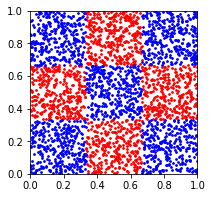

In [50]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
def plot_checkerboard(X,y):
    plt.figure(figsize=(3,3))
    plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
    plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
    plt.xlim([0,1])
    plt.ylim([0,1]);
    

plot_checkerboard(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=317)

In [105]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
# options = [['poly', {'degree':range(2,5),'C': np.logspace(-3,2,5)}],['rbf',{'gamma': [1, 0.1, 0.01, 0.001],'C': np.logspace(-3,2,5)}]]
X_train, y_train = checkerboard(3000)
options = [['poly', {'svc__degree':range(2,5),'svc__C': np.logspace(-3,2,5)}],['rbf',{'svc__gamma': [1, 0.1, 0.01, 0.001],'svc__C': np.logspace(-3,2,5)}]]

for i in [0,1]:
    kernel = options[i][0]
    parameters = options[i][1]
    clf = make_pipeline(StandardScaler(), SVC(kernel=kernel))
    grid_GBC = GridSearchCV(clf, parameters)
    grid_GBC.fit(X_train, y_train)

    best_params = grid_GBC.best_params_

    # sorted(gsc.cv_results_.keys())

    print(f" Results from Grid Search for _{kernel}_:" )
    print("\n The best estimator across ALL searched params on TRAIN set:\n",grid_GBC.best_estimator_)
    print("\n The best score across ALL searched params on TRAIN set:\n",grid_GBC.best_score_)
    print("\n The best parameters across ALL searched params on TRAIN set:\n",best_params)

    print('')


 Results from Grid Search for _poly_:

 The best estimator across ALL searched params on TRAIN set:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.31622776601683794, degree=4, kernel='poly'))])

 The best score across ALL searched params on TRAIN set:
 0.8546666666666667

 The best parameters across ALL searched params on TRAIN set:
 {'svc__C': 0.31622776601683794, 'svc__degree': 4}

 Results from Grid Search for _rbf_:

 The best estimator across ALL searched params on TRAIN set:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=1))])

 The best score across ALL searched params on TRAIN set:
 0.9890000000000001

 The best parameters across ALL searched params on TRAIN set:
 {'svc__C': 100.0, 'svc__gamma': 1}



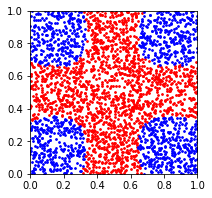

In [106]:
from sklearn.metrics import classification_report

X_test, y_test = checkerboard(3000)

svc = SVC(C=0.31622776601683794, degree=4, kernel='poly')
clf = make_pipeline(StandardScaler(), svc)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
plot_checkerboard(X_test,y_pred)

# cv = svc.support_vectors_
# plt.scatter(cv[:,0],cv[:,1],c='g',)
# print(svc.support_vectors_)

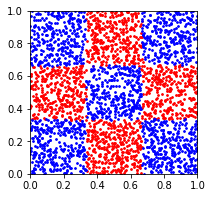

In [107]:
svc = SVC(C=100.0, gamma=1, kernel='rbf')
clf = make_pipeline(StandardScaler(), svc)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
plot_checkerboard(X_test,y_pred)

# cv = svc.support_vectors_
# plt.scatter(cv[:,0],cv[:,1],c='g',)
# print(svc.support_vectors_)

### Answer:

The model with Gaussian kernel did a better job in our case.

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

